<a href="https://colab.research.google.com/github/mervenurerdogan/CA_NORMAL/blob/main/ConvNeXt_tiny_CA_NORMAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq timm


     |████████████████████████████████| 549 kB 9.5 MB/s 
     |████████████████████████████████| 182 kB 33.4 MB/s 


In [2]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 719 kB 15.8 MB/s 
     |████████████████████████████████| 451 kB 57.5 MB/s 
     |████████████████████████████████| 5.5 MB 62.3 MB/s 
     |████████████████████████████████| 1.3 MB 56.8 MB/s 
     |████████████████████████████████| 1.6 MB 52.9 MB/s 
     |████████████████████████████████| 212 kB 71.2 MB/s 
     |████████████████████████████████| 115 kB 68.6 MB/s 
     |████████████████████████████████| 127 kB 72.1 MB/s 
     |████████████████████████████████| 7.6 MB 45.3 MB/s 
Mounted at /content/gdrive


In [3]:
import timm
from fastbook import *
from fastai.vision.all import *

In [16]:
all_convnext_models = timm.list_models('*convnext*')
all_convnext_models

['convnext_atto',
 'convnext_atto_ols',
 'convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_femto',
 'convnext_femto_ols',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_nano',
 'convnext_nano_ols',
 'convnext_pico',
 'convnext_pico_ols',
 'convnext_small',
 'convnext_small_384_in22ft1k',
 'convnext_small_in22ft1k',
 'convnext_small_in22k',
 'convnext_tiny',
 'convnext_tiny_384_in22ft1k',
 'convnext_tiny_hnf',
 'convnext_tiny_in22ft1k',
 'convnext_tiny_in22k',
 'convnext_xlarge_384_in22ft1k',
 'convnext_xlarge_in22ft1k',
 'convnext_xlarge_in22k']

In [4]:
from zipfile import ZipFile
file_name='/content/gdrive/MyDrive/BinaryDataEdit.zip'

In [5]:
with ZipFile (file_name,'r') as zip:
  zip.extractall()
  print('done')

done


In [6]:
path=Path('/content/BinaryDataEdit/Lung_Binary_CA_Normal')


In [6]:
path.ls()


In [7]:
train_fnames=get_image_files(path/'Train')
all_files=get_image_files(path)

In [8]:
from fastai.vision.augment import contrast
tfms = aug_transforms(size=224, 
                      min_scale=0.75,
                      do_flip=True,
                      flip_vert=True,
                      max_rotate=360,
                      max_warp=0,
                      max_zoom=1.1,
                      max_lighting=0.1,
                      p_lighting=0.5
                      
                      
                      )

In [9]:
dblock=DataBlock(blocks=(ImageBlock(cls=PILImage),CategoryBlock),
                 splitter=GrandparentSplitter(train_name='Train',valid_name='Valid'),
                 get_y=parent_label,
                 item_tfms=Resize(224,method='squish'),
                 batch_tfms=tfms
                 
                 
)

In [10]:
dls=dblock.dataloaders(all_files,bs=16)


In [11]:
train_df = len(train_fnames)
print(f"There are {train_df} images")

There are 4129 images


In [12]:
valid_fnames=get_image_files(path/'Valid')
valid_df = len(valid_fnames)
print(f"There are {valid_df} images")

There are 500 images


In [13]:
test_fnames=get_image_files(path/'Test')
test_df = len(test_fnames)
print(f"There are {test_df} images")

There are 529 images


In [14]:
dls.c,len(dls.train_ds),len(dls.valid_ds)


(2, 4129, 500)

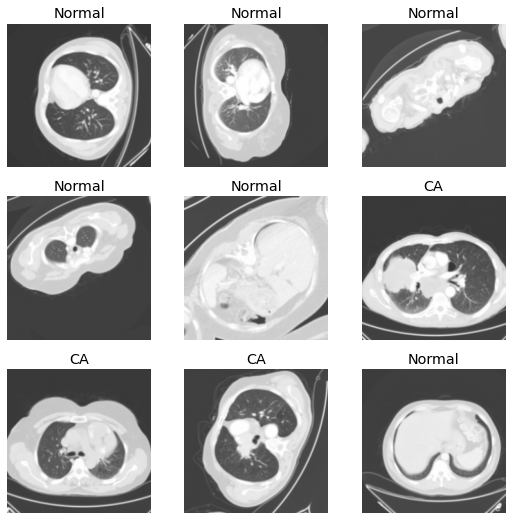

In [15]:
dls.show_batch()


In [17]:
learn = vision_learner(dls,'convnext_tiny_in22k',  metrics=accuracy)


Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_tiny_22k_224.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny_22k_224.pth


In [18]:
learn.summary()

Sequential (Input shape: 16 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     16 x 96 x 56 x 56   
Conv2d                                    4704       False     
LayerNorm2d                               192        True      
Identity                                                       
Conv2d                                    4800       False     
LayerNorm                                 192        True      
____________________________________________________________________________
                     16 x 56 x 56 x 384  
Linear                                    37248      False     
GELU                                                           
Dropout                                                        
____________________________________________________________________________
                     16 x 56 x 56 x 96   
Linear                                    36960      False     
Dropout                            

SuggestedLRs(valley=0.0030199517495930195)

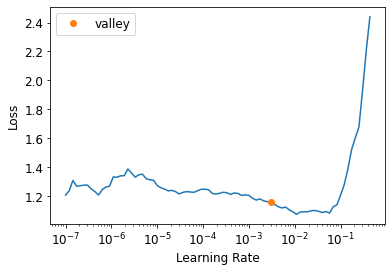

In [19]:
learn.lr_find()


In [20]:
learn.fine_tune(40,1e-3)


epoch,train_loss,valid_loss,accuracy,time
0,0.684040,0.432161,0.868000,01:24


epoch,train_loss,valid_loss,accuracy,time
0,0.435770,0.214654,0.912000,01:56
1,0.374131,0.142535,0.940000,01:54
2,0.360747,0.167144,0.940000,01:54
3,0.284356,0.131626,0.954000,01:55
4,0.276109,0.170817,0.942000,01:54
5,0.270465,0.140338,0.956000,01:55
6,0.236516,0.162925,0.954000,01:54
7,0.169989,0.132764,0.962000,01:54
8,0.187900,0.148583,0.962000,01:55
9,0.202958,0.145983,0.954000,01:55


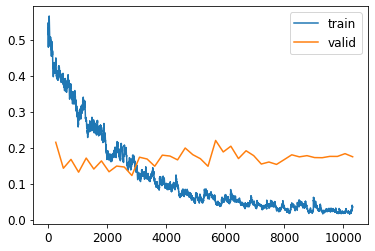

In [21]:
learn.recorder.plot_loss()


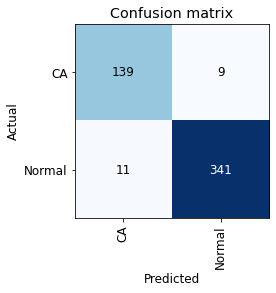

In [22]:
interp=ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [23]:
interp.print_classification_report()


              precision    recall  f1-score   support

          CA       0.93      0.94      0.93       148
      Normal       0.97      0.97      0.97       352

    accuracy                           0.96       500
   macro avg       0.95      0.95      0.95       500
weighted avg       0.96      0.96      0.96       500



In [24]:
preds, targs = learn.tta()
accuracy(preds, targs).item()

0.9660000205039978

In [25]:
interp.most_confused()


[('Normal', 'CA', 11), ('CA', 'Normal', 9)]

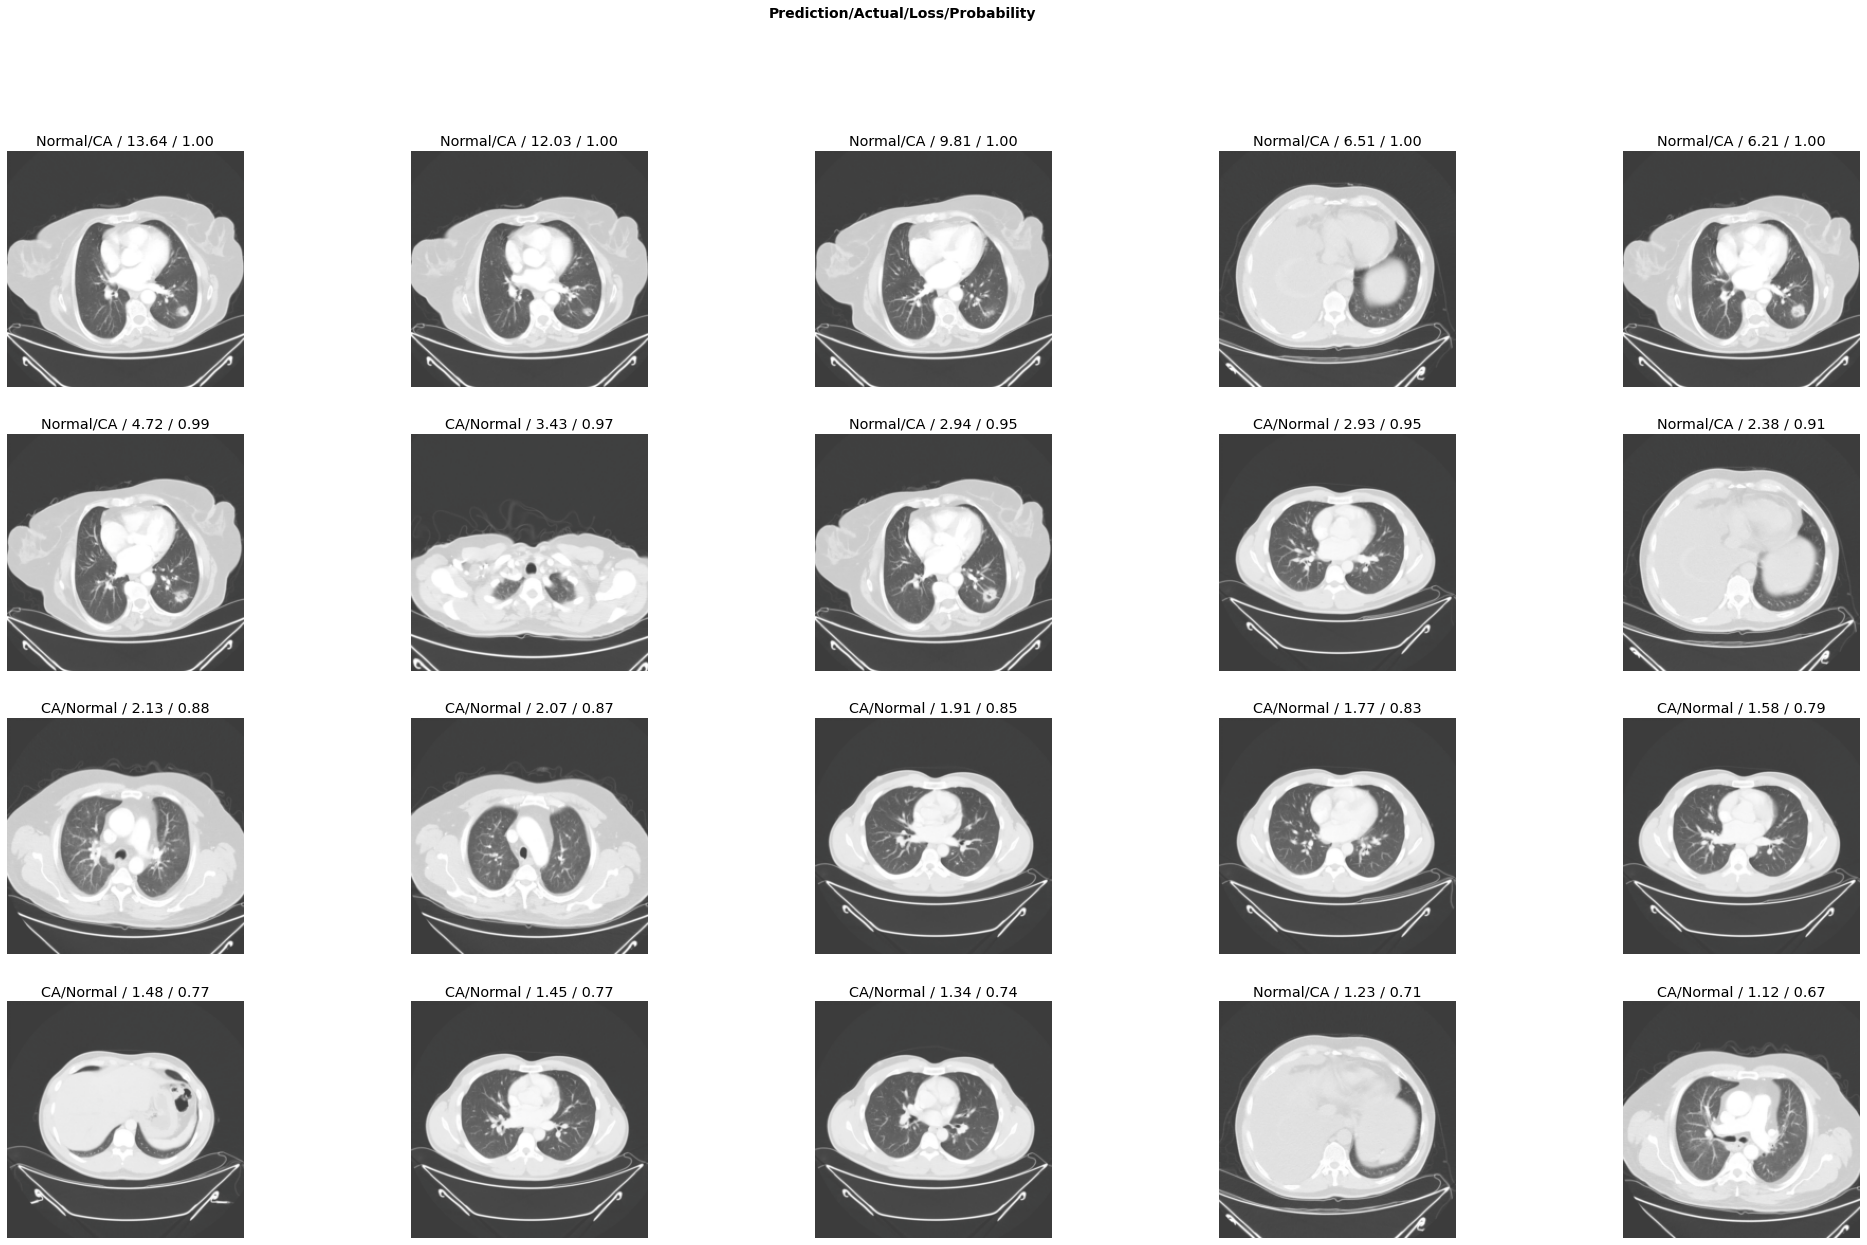

In [27]:
interp.plot_top_losses(20, figsize=(35,20))


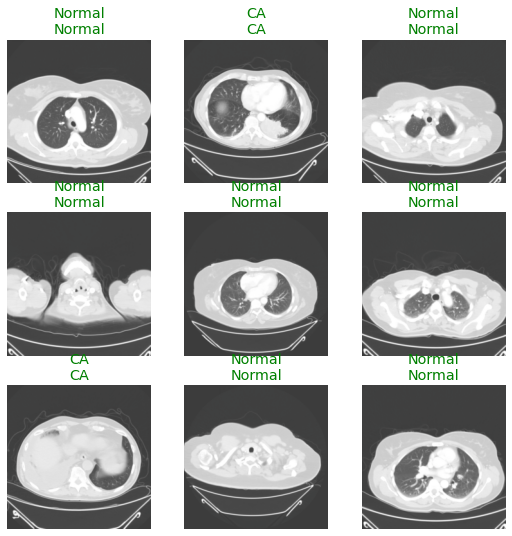

In [28]:
learn.show_results()


In [29]:
learn.save(path/'CA_Normal_ConvNext_Small_Train')


Path('/content/BinaryDataEdit/Lung_Binary_CA_Normal/CA_Normal_ConvNext_Small_Train.pth')

In [30]:
learn.export(path/'CA_Normal_ConvNext_Small_Train_Exp.pkl')


In [31]:
dblock=DataBlock(blocks=(ImageBlock(cls=PILImage),CategoryBlock),
                 splitter=GrandparentSplitter(train_name='Train',valid_name='Test'),
                 get_y=parent_label,
                 item_tfms=Resize(224,method='squish'),
                 batch_tfms=tfms
                 
                 
)

In [32]:
dls_test = dblock.dataloaders(all_files)


In [33]:
learn1= learn = vision_learner(dls_test,'convnext_tiny_in22k',  metrics=accuracy).load('/content/BinaryDataEdit/Lung_Binary_CA_Normal/CA_Normal_ConvNext_Small_Train')


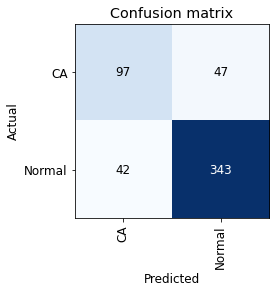

In [34]:
interp = ClassificationInterpretation.from_learner(learn1)
interp.plot_confusion_matrix()

In [35]:
interp.print_classification_report()


              precision    recall  f1-score   support

          CA       0.70      0.67      0.69       144
      Normal       0.88      0.89      0.89       385

    accuracy                           0.83       529
   macro avg       0.79      0.78      0.79       529
weighted avg       0.83      0.83      0.83       529



In [36]:
preds, targs = learn.tta()
accuracy(preds, targs).item()

0.746691882610321

In [37]:
interp.most_confused()


[('CA', 'Normal', 47), ('Normal', 'CA', 42)]

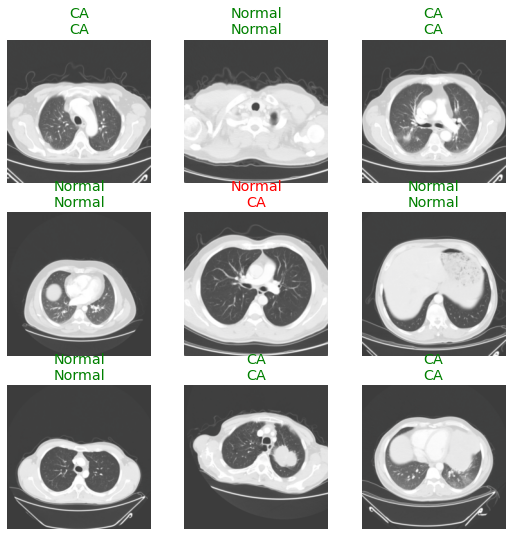

In [38]:
learn1.show_results()


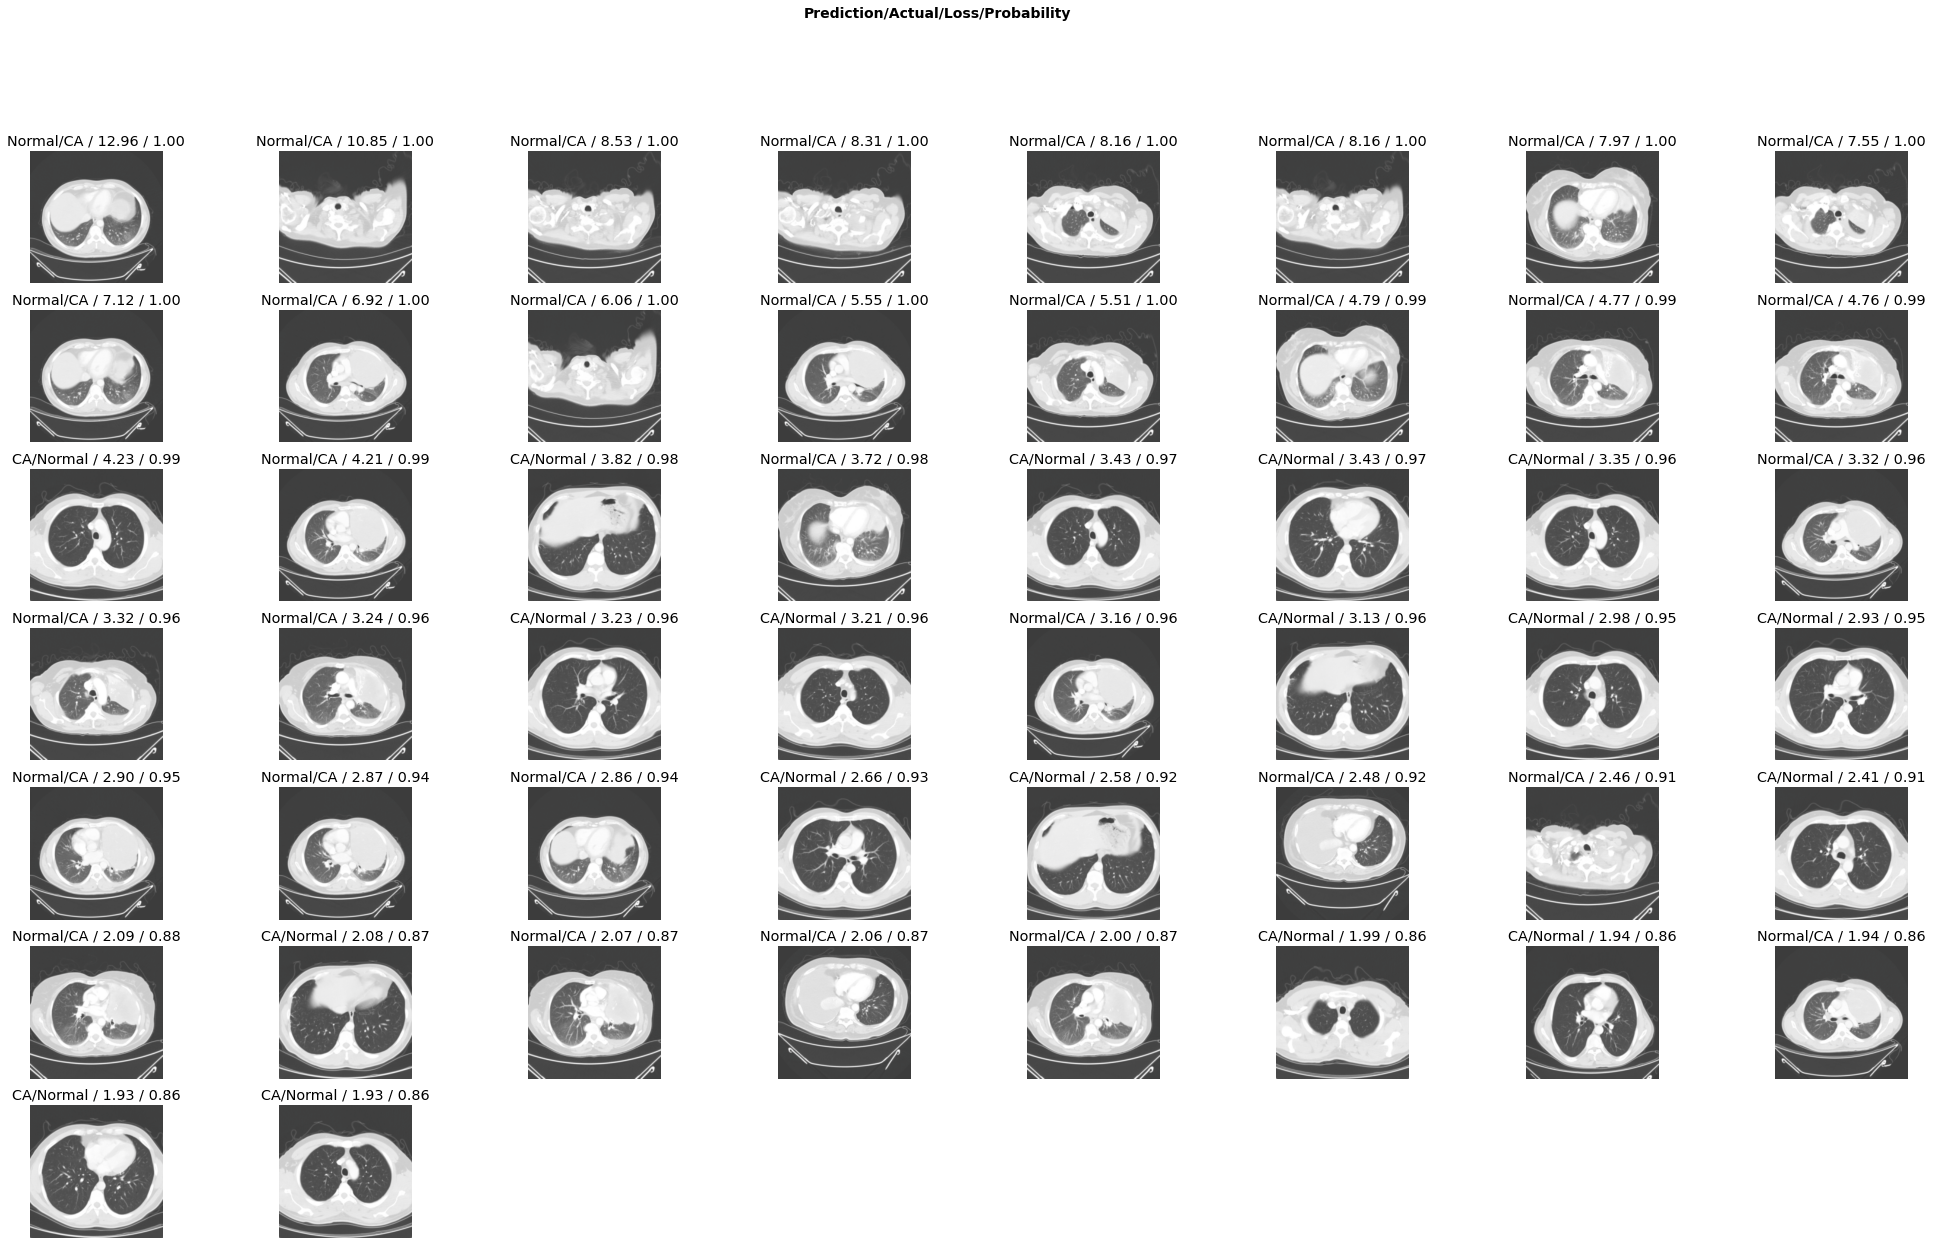

In [39]:
interp.plot_top_losses(50, figsize=(35,20))


In [40]:
losses,idxs = interp.top_losses(84)
print(idxs)

TensorBase([ 25,  42,  22, 119,  64, 131,  38,  93, 117,  21, 128,  74,  31,  79, 100, 106, 314,  40, 322,   5, 391, 312, 199,  61, 109,   7, 324, 212,  18, 495, 408, 171,  89,   6, 125, 522, 258,
             39,   2, 157,  86, 278, 116, 141,  44, 318, 159,  24, 181, 335, 277,  66, 110, 164,  51,  56, 124, 253, 513, 446,  47, 142, 113, 527,  57, 197, 252, 264, 458,   3, 514, 339,  43, 134,
            387, 269, 439, 386, 203, 162,  68, 291, 103, 405])


In [41]:
dls_test.valid_ds.items[55]


Path('/content/BinaryDataEdit/Lung_Binary_CA_Normal/Test/CA/IMG-0132-00046.bmp')

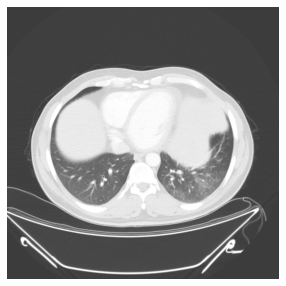

In [42]:
img = PILImage.create('/content/BinaryDataEdit/Lung_Binary_CA_Normal/Test/CA/IMG-0132-00046.bmp')
img.show()

In [43]:
learn.predict(img)


('CA', TensorBase(0), TensorBase([0.6874, 0.3126]))

In [44]:
dls_test.valid_ds.items[300]


Path('/content/BinaryDataEdit/Lung_Binary_CA_Normal/Test/Normal/IMG-0132-00026.bmp')

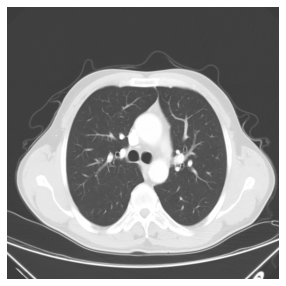

In [45]:
img = PILImage.create('/content/BinaryDataEdit/Lung_Binary_CA_Normal/Test/Normal/IMG-0132-00026.bmp')
img.show()

In [46]:
learn.predict(img)


('Normal', TensorBase(1), TensorBase([0.0012, 0.9988]))

In [47]:
dls_test.valid_ds.items[56]


Path('/content/BinaryDataEdit/Lung_Binary_CA_Normal/Test/CA/IMG-0122-00011.bmp')

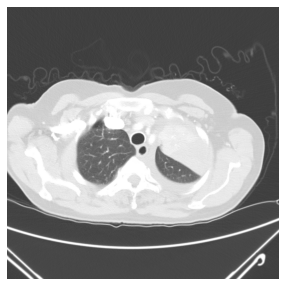

In [48]:
img = PILImage.create('/content/BinaryDataEdit/Lung_Binary_CA_Normal/Test/CA/IMG-0122-00011.bmp')
img.show()

In [49]:
learn.predict(img)


('Normal', TensorBase(1), TensorBase([0.1743, 0.8257]))

In [50]:
dls_test.valid_ds.items[8]


Path('/content/BinaryDataEdit/Lung_Binary_CA_Normal/Test/CA/IMG-0130-00019.bmp')

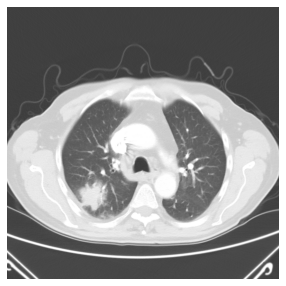

In [51]:
img = PILImage.create('/content/gdrive/MyDrive/LUNG_DATA adlı dosyanın kopyası/Lung_Binary_CA_Pneumonia/Test/CA/IMG-0130-00019.bmp')
img.show()

In [52]:
learn.predict(img)

('CA', TensorBase(0), TensorBase([9.9902e-01, 9.8054e-04]))

In [53]:
class HookActivation():
    def __init__(self, target_layer):
        """Initialize a Pytorch hook using `hook_activation` function."""

        self.hook = target_layer.register_forward_hook(self.hook_activation) 
        
    def hook_activation(self, target_layer, activ_in, activ_out): 
        """Create a copy of the layer output activations and save 
        in `self.stored`.
        """
        self.stored = activ_out.detach().clone()
        
    def __enter__(self, *args): 
        return self
    
    def __exit__(self, *args): 
        self.hook.remove()

        
class HookGradient():
    def __init__(self, target_layer):
        """Initialize a Pytorch hook using `hook_gradient` function."""
        
        self.hook = target_layer.register_backward_hook(self.hook_gradient)   
        
    def hook_gradient(self, target_layer, gradient_in, gradient_out): 
        """Create a copy of the layer output gradients and save 
        in `self.stored`.
        """
        self.stored = gradient_out[0].detach().clone()
        
    def __enter__(self, *args): 
        return self

    def __exit__(self, *args): 
        self.hook.remove()

In [54]:
m = learn1.model.eval();
m;

In [97]:
target_layer = learn1.model[0]

target_layer;

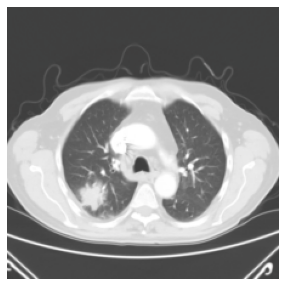

In [66]:
x, = first(dls_test.test_dl([img]))

x_img = TensorImage(dls_test.train.decode((x,))[0][0])
x_img.show()

In [67]:
learn1.predict(img)

('CA', TensorBase(0), TensorBase([9.9902e-01, 9.8054e-04]))

In [77]:
class Hook():
    def hook_func(self, m, i, o): self.stored = o.detach().clone()

In [84]:
hook_output = Hook()
hook = learn1.model[0].register_forward_hook(hook_output.hook_func)

In [85]:
with torch.no_grad(): output = learn1.model.eval()(x)


In [86]:
act = hook_output.stored[0]


In [91]:
F.softmax(output, dim=0)


TensorBase([[1., 1.]], device='cuda:0')

In [92]:
x.shape


torch.Size([1, 3, 224, 224])